In [1]:
#IMPORTS

%run ../datuslib.ipynb
%run Functions.ipynb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn import datasets
from sklearn import pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,scale, normalize
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import time

# graficos incrustados
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def plotCM(cm,classes=None,title='Matriz de Confusion'):
    if classes is not None:
        sns.heatmap(cm,xticklabels=classes,yticklabels=classes,vmin=0.,vmax=1.,annot=True,annot_kws={'size':50})
    else:
        sns.heatmap(cm,vmin=0.,vmax=1.)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predecida')
    
def checkDummyModel(xTrain,yTrain,xTest,yTest):
    dummyCf=DummyClassifier(strategy='most_frequent')
    dummyCf.fit(xTrain,yTrain)
    punjate=dummyCf.score(xTest,yTest)
    predict=dummyCf.predict(xTest)
    f1Score=f1_score(yTest,predict)
    print('Score:',punjate)
    print('f1Score:',f1Score)
    return predict

def runRF(rfModel,x_train,y_train,x_test,y_test,to_predict,perfect_sub):
    # ENTRENAMOS EL MODELO CON LOS DATOS
    rfModel.fit(x_train, y_train)

    # TOMAMOS LA IMPORTANCIA NUMERICA DE LOS FEATURES
    importances = list(rfModel.feature_importances_)
    feature_list = list(x_train.columns)

    # USAMOS EL MODELO PARA PREDECIR
    predictions = rfModel.predict(x_train)
    prediction_train_round= np.around(rfModel.predict(x_train))
    print ("F1 Score train: ", f1_score(y_train, prediction_train_round))

    predictions = rfModel.predict(x_test)
    prediction_test_round= np.around(rfModel.predict(x_test))
    print ("F1 Score test: ", f1_score(y_test, prediction_test_round))
    
    dummyPrediction=getDummyLabelToTest(y_test)
    print ("F1 Score dummy test: ", f1_score(y_test, dummyPrediction))

    prediction_to_predict_round= np.around(rfModel.predict(to_predict)).astype(int)
    f1real=f1_score(perfect_sub.target, prediction_to_predict_round)
    print ("F1 Score to_predict: ",f1real)
    
    print ("F1 Score dummy perfect target: ",f1_score(perfect_sub.target, getDummyLabelToTest(perfect_sub.target)))
    

    return [pd.Series(prediction_to_predict_round),feature_list,importances,rfModel.estimators_[5],f1real]

def graficarImportancia(feature_list,importances,title='Importancia de los Featuares'):
    # SETEAMOS EL ESTILO
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=(20,10))

    # LISTA DE LOS VALORES DE X PARA PLOTTEAR
    x_values = list(range(len(importances)))


    # GENERAMOS EL GRAFICO DE BARRAS
    plt.bar(x_values, importances, orientation = 'vertical')

    # COLOCAMOS LAS ETIQUETAS PARA EL EJE X
    plt.xticks(x_values, feature_list, rotation='vertical')

    # ETIQUETAS DE EJES Y TITULO
    plt.ylabel('Importancia'); plt.xlabel('Features'); plt.title(title)
    
    
def tomarXfeaturesImportantes(cantidadFeateares,feature_list,importances):
    df_feature_importance=pd.DataFrame(importances)
    df_feature_importance['feature']=feature_list
    df_feature_importance.columns=['Importancia','Features']
    df_feature_importance=df_feature_importance[['Features','Importancia']]
    return df_feature_importance.nlargest(cantidadFeateares,'Importancia')

def exportarArbolEjemplo(estimador,lista_features,nombreSalida='tree.png'):
    export_graphviz(estimador, out_file = 'tree.dot', feature_names = lista_features, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('tree.dot')

    # GUARDAMOS EL GRAFICO EN EL ARCHIVO PNG
    graph.write_png(nombreSalida)
    
def getDummyLabelToTest(serieToTest):
    valor_mas_frecuente=pd.Series(serieToTest).value_counts().idxmax()
    return pd.Series(valor_mas_frecuente).repeat(len(serieToTest))

In [3]:
perfect_sub = pd.read_csv("../Data/perfect_submission.csv")

# CARGO LOS FEATURES

In [4]:
to_predict=pd.read_csv('to_predict.csv')
to_predict=to_predict*1
print (to_predict.shape)
to_predict.head()

(3263, 204)


,len,word_count,unique_word_count,url_count,mean_word_length,hashtag_count,mention_count,key_bit0,key_bit1,key_bit2,...,Tiene_deaths,Tiene_climate,Tiene_plague,Tiene_disappearance,Tiene_missing,Tiene_floods,Tiene_delug,contains_keyword,Tiene_key_impor,Tiene_key_no_impor
0,0.121429,6,6,0,4.833333,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.228571,9,9,0,6.222222,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.342857,19,19,0,4.105263,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.142857,4,4,0,9.250000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.160714,8,8,0,4.750000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_train=pd.read_csv('x_train.csv')
x_train=x_train*1
print (x_train.shape)
x_train.head()

(5709, 204)


,len,word_count,unique_word_count,url_count,mean_word_length,hashtag_count,mention_count,key_bit0,key_bit1,key_bit2,...,Tiene_deaths,Tiene_climate,Tiene_plague,Tiene_disappearance,Tiene_missing,Tiene_floods,Tiene_delug,contains_keyword,Tiene_key_impor,Tiene_key_no_impor
0,0.485714,22,21,0,5.227273,0,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.457143,17,17,1,6.588235,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.489286,29,29,0,3.758621,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
3,0.189286,12,11,0,3.500000,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.189286,6,6,0,8.000000,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
x_test=pd.read_csv('x_test.csv')
x_test=x_test*1
print (x_test.shape)
x_test.head()

(1904, 204)


,len,word_count,unique_word_count,url_count,mean_word_length,hashtag_count,mention_count,key_bit0,key_bit1,key_bit2,...,Tiene_deaths,Tiene_climate,Tiene_plague,Tiene_disappearance,Tiene_missing,Tiene_floods,Tiene_delug,contains_keyword,Tiene_key_impor,Tiene_key_no_impor
0,0.235714,11,11,0,5.090909,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.425000,21,20,0,4.714286,1,4,0,1,0,...,0,0,0,0,0,0,1,1,0,0
2,0.446429,15,15,1,7.400000,0,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.407143,21,20,0,4.476190,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0.375000,17,17,0,5.235294,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
y_train=pd.read_csv('y_train.csv')
y_train=y_train.target
print (y_train.shape)
y_train.head()

(5709,)


0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64

In [8]:
y_test=pd.read_csv('y_test.csv')
y_test=y_test.target
print (y_test.shape)
y_test.head()

(1904,)


0    1
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [9]:
ids=pd.read_csv('ids.csv')
ids=ids.id
print (ids.shape)
ids.head()

(3263,)


0     0
1     2
2     3
3     9
4    11
Name: id, dtype: int64

# COMIENZO CON EL ALGORITMO

In [10]:
from sklearn.ensemble import RandomForestRegressor

# INSTANCIAMOS EL MODELO ESTANDAR

rfr = RandomForestRegressor(random_state=42)
rf_result=runRF(rfr,x_train,y_train,x_test,y_test,to_predict,perfect_sub)

rf_predict=rf_result[0]
feature_list=rf_result[1]
importances=rf_result[2]
estimador=rf_result[3]
score_base=rf_result[4]

F1 Score train:  0.9938693291294447
F1 Score test:  0.9695378151260505
F1 Score dummy test:  0.5730042016806722
F1 Score to_predict:  0.7162120747778118
F1 Score dummy perfect target:  0.5703340484216978


# GRAFICO DE IMPORTANCIA DE LOS FEATURES

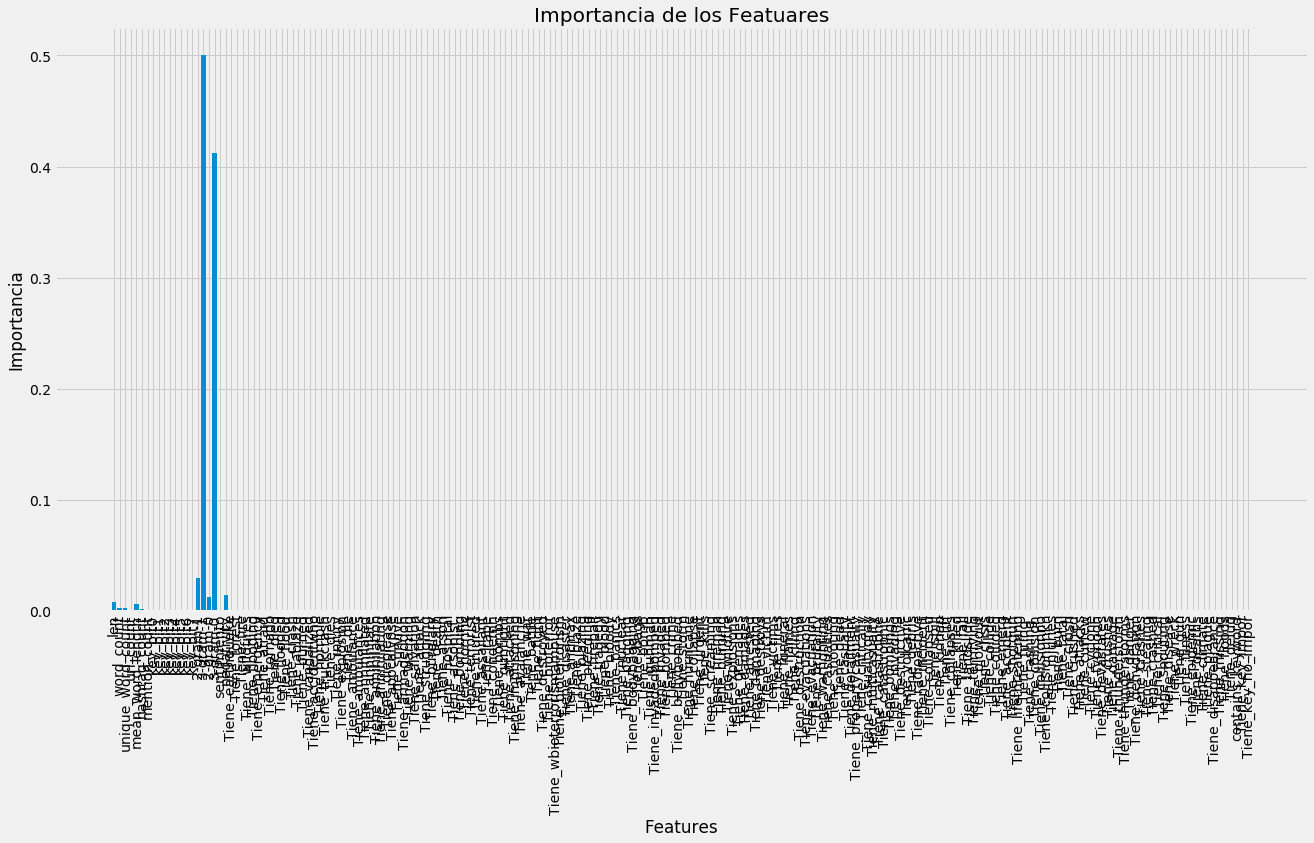

In [11]:
graficarImportancia(feature_list,importances)

# Verifico el top 40 de los Features mas importantes

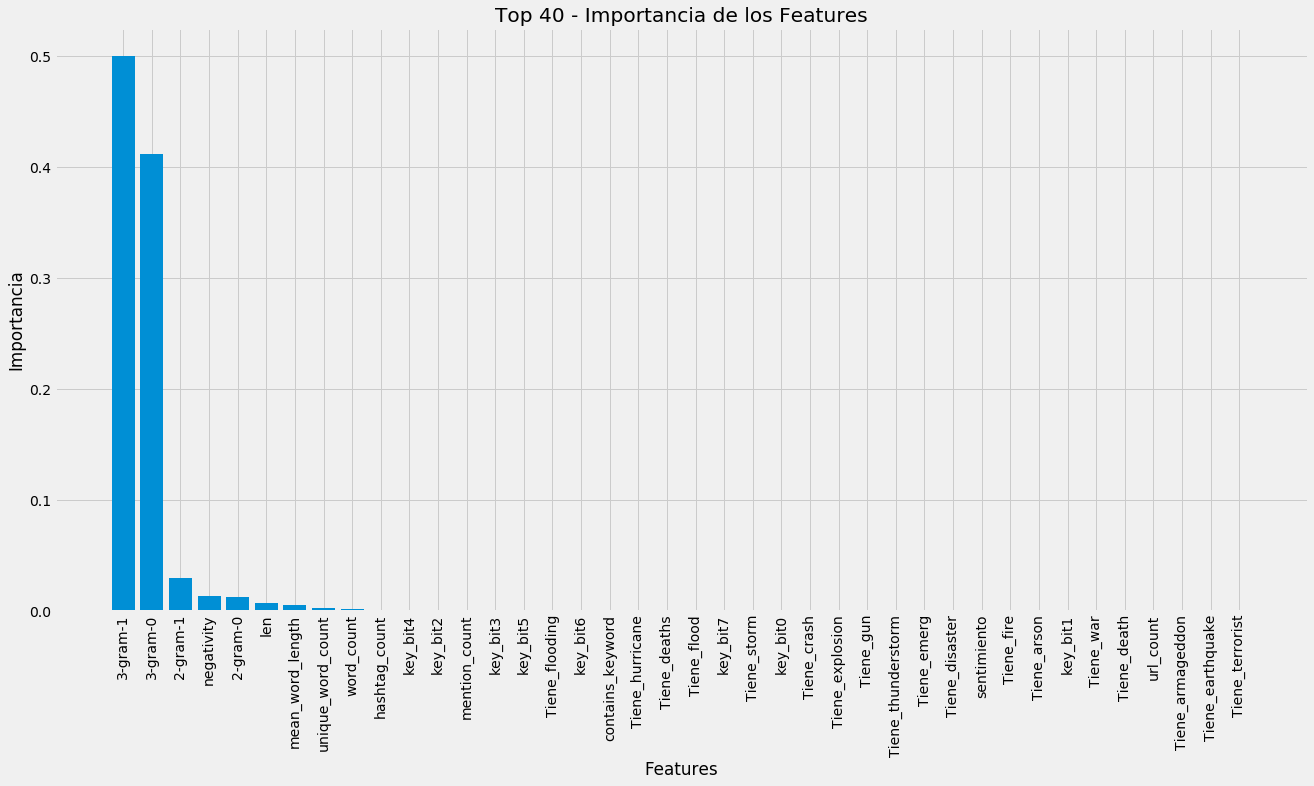

In [12]:
df_top_40_features=tomarXfeaturesImportantes(40,feature_list,importances)
graficarImportancia(df_top_40_features.Features,df_top_40_features.Importancia,'Top 40 - Importancia de los Features')

# Visualizo los features del 10 al 40

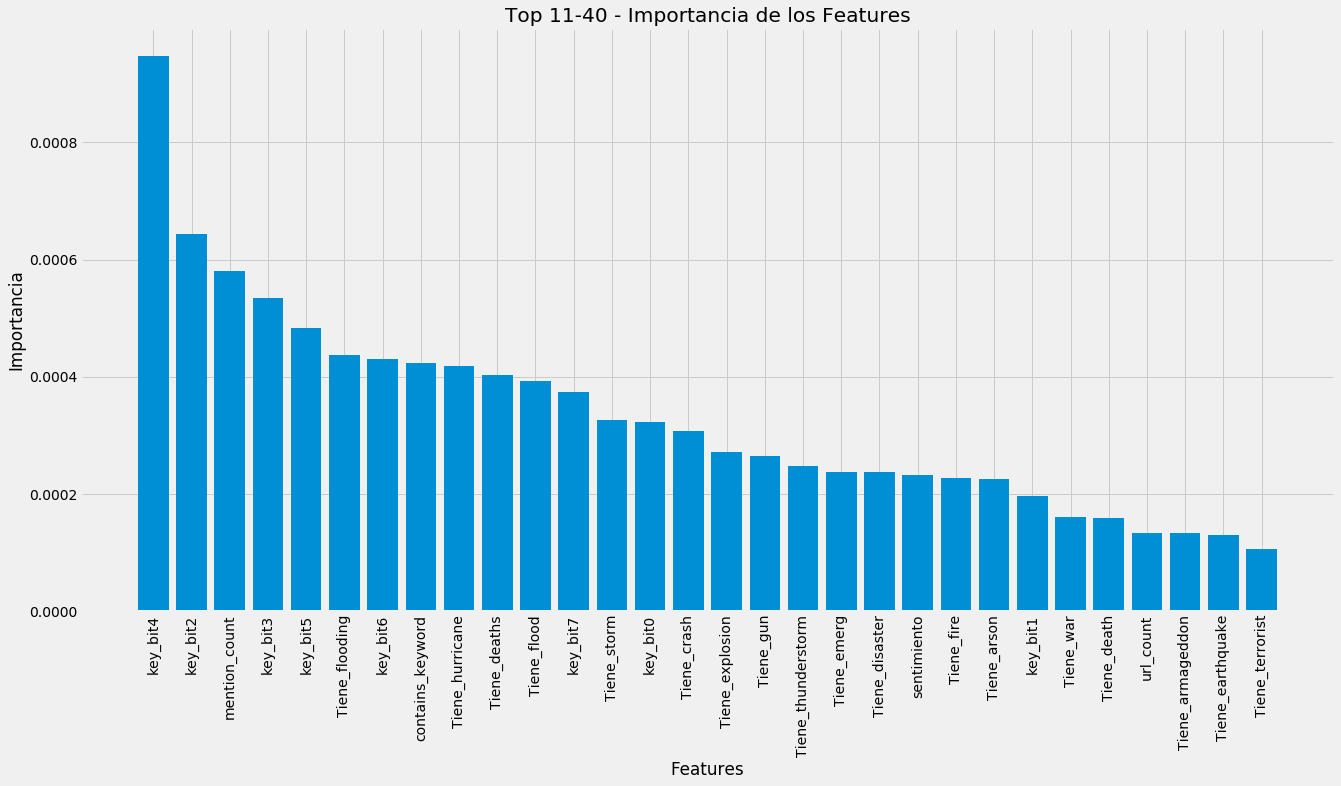

In [13]:
graficarImportancia(df_top_40_features.Features[10:],df_top_40_features.Importancia[10:],'Top 11-40 - Importancia de los Features')

# SUBMIT DE MODELO BASE

In [14]:
#SUBMIT DE MODELO BASE
result = submission_output(ids, rf_predict,"RF_BASE.csv")
result.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0


# PRUEBA DE RANDOM FOREST CON LOS 20 FEATURES MAS IMPORTANTES

In [15]:
df_top_20_features=tomarXfeaturesImportantes(20,feature_list,importances)
feature_list_top_20 = df_top_20_features.Features.to_list()

to_predict_top_20=to_predict.loc[:,feature_list_top_20]
print (to_predict_top_20.shape)
print('-----------')
x_train_top_20=x_train.loc[:,feature_list_top_20]
print ('x_train_top_20:',x_train_top_20.shape)
print('-----------')
print ('y_train:',y_train.shape)
print('-----------')
x_test_top_20=x_test.loc[:,feature_list_top_20]
print ('x_test_top_20:',x_test_top_20.shape)
print('-----------')
print ('y_test:',y_test.shape)
print('-----------')

#ENTRENO MODELO BASE REDUCIDO
rfr = RandomForestRegressor(random_state=42)

result_top_20=runRF(rfr,x_train_top_20,y_train,x_test_top_20,y_test,to_predict_top_20,perfect_sub)
print('Top 20 features y Diferencia entre score Base:',result_top_20[4]-score_base)

(3263, 20)
-----------
x_train_top_20: (5709, 20)
-----------
y_train: (5709,)
-----------
x_test_top_20: (1904, 20)
-----------
y_test: (1904,)
-----------
F1 Score train:  0.9938693291294447
F1 Score test:  0.967436974789916
F1 Score dummy test:  0.5730042016806722
F1 Score to_predict:  0.7189702727551335
F1 Score dummy perfect target:  0.5703340484216978
Top 20 features y Diferencia entre score Base: 0.002758197977321686


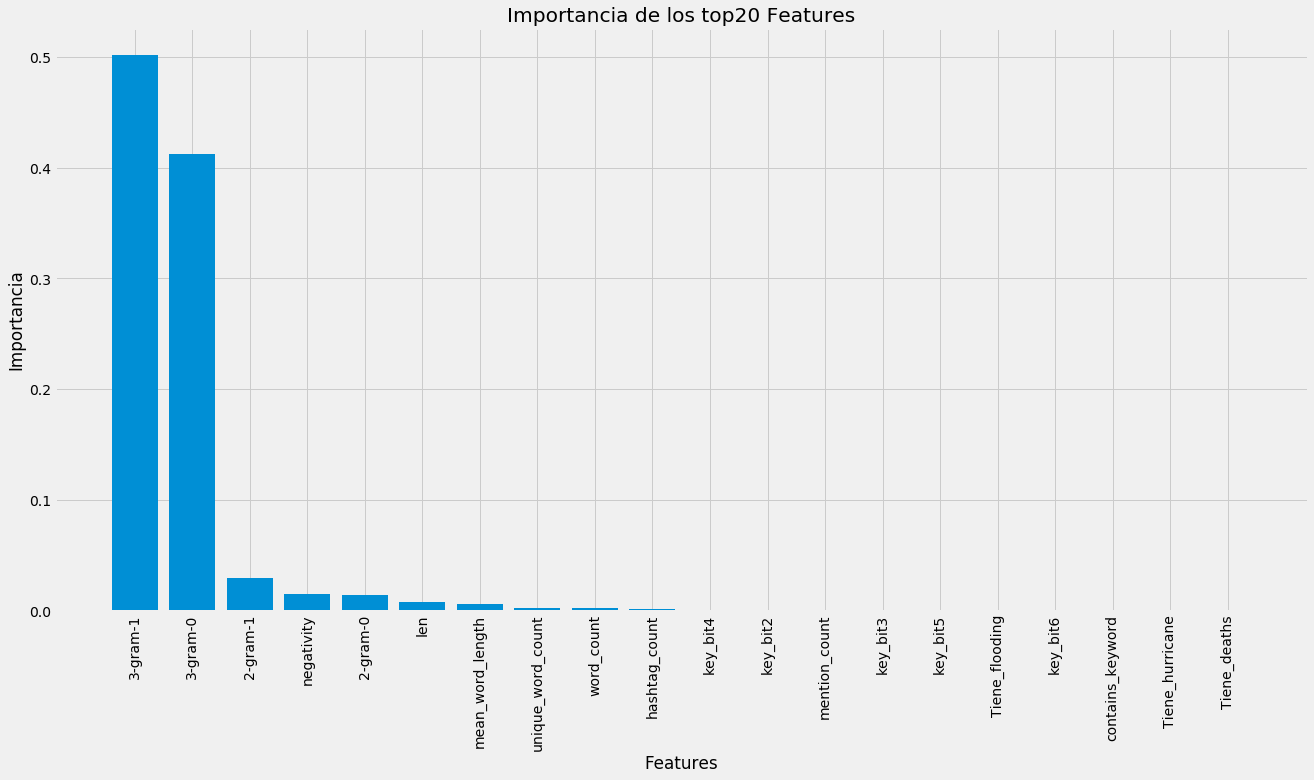

In [16]:
graficarImportancia(result_top_20[1],result_top_20[2],'Importancia de los top20 Features')

# VEO COMO ES UN ARBOL MODELO

In [17]:
exportarArbolEjemplo(result_top_20[3],result_top_20[1],'arbol_ejemplo_top_20_feature.png')

# ----------------------------------------------------------------------

# ----------------------------------------------------------------------

# ----------------------------------------------------------------------

# TUNEO EL MODELO

In [18]:
results=[]
best_results=[]
all_params=[]
temporal_best = 0

# PRUEBO UN KNN BUSCANDO LOS N VECINOS PARA VER COMO SE COMPORTA RF

In [33]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, x_train, y_train,scoring='f1_micro',cv=5).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,111))
}

results=[]
best_results=[]
all_params=[]
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    results.append(acc)
    all_params.append(params['n_neighbors'])
    if acc > best:
        best = acc
        best_results.append(acc)
    print ('new best:', best, params)
    return {'loss': 1-acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
0.9590105029324569                                                                                                     
{'n_neighbors': 75}                                                                                                    
new best:                                                                                                              
0.9661927325107806                                                                                                     
{'n_neighbors': 13}                                                                                                    
new best:                                                                                                              
0.9661927325107806                                                                                                     
{'n_neighbors': 58}                     

0.967419726644384                                                                                                      
{'n_neighbors': 55}                                                                                                    
new best:                                                                                                              
0.967419726644384                                                                                                      
{'n_neighbors': 92}                                                                                                    
new best:                                                                                                              
0.967419726644384                                                                                                      
{'n_neighbors': 11}                                                                                                    
new best:                               

Text(0.5, 1.0, 'N seleccionados (Bayesian Optimization)')

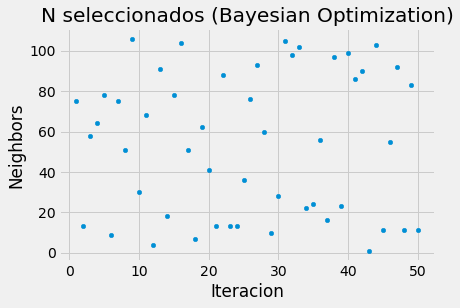

In [79]:
df_n_knn=pd.DataFrame(all_params)
df_n_knn=df_n_knn.reset_index()
df_n_knn['index']=df_n_knn.index+1
df_n_knn.columns=['Iteracion','Neighbors']
df_n_knn.plot.scatter('Iteracion','Neighbors')
plt.title('N seleccionados (Bayesian Optimization)')
    

Text(0.5, 1.0, 'N seleccionados (Variacion lineal)')

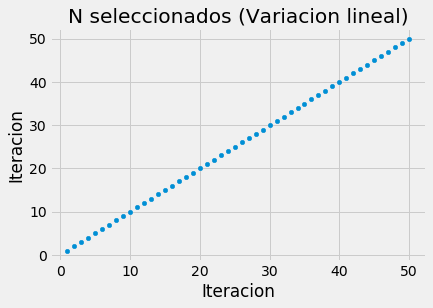

In [80]:
df_n_knn.plot.scatter('Iteracion','Iteracion')
plt.title('N seleccionados (Variacion lineal)')

In [149]:
knn=KNeighborsClassifier(n_neighbors=14)
# Fitting the model
knn.fit(x_train, y_train)

# Predicting the Test set results
y_pred = knn.predict(x_train)
f1_score(y_train, y_pred,average='micro')

0.9682956734979856

In [150]:
knn_pred=knn.predict(to_predict)
knn_pred

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [151]:
f1_score(perfect_sub.target, knn_pred)

0.7624885075084278

In [152]:
knn_tunning=submission_output(ids, knn_pred,"knn_tunning.csv")
knn_tunning.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [96]:
results=[]
params_list=[]
best_results=[]
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, x_train, y_train,scoring='f1',cv=5).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,150)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [42])}

best = 0
def f(params):
    global best
    params_list.append(params)
    acc = acc_model(params)
    results.append(acc)
    if acc > best:
        best = acc
        best_results.append(acc)
    else:
        best_results.append(best_results[-1])
    print ('new best:', best, params)
    return {'loss': 1-acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
0.9646179301668927                                                                                                     
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 69, 'n_estimators': 278, 'random_state': 42}                 
new best:                                                                                                              
0.9693467846296915                                                                                                     
{'criterion': 'gini', 'max_depth': 9, 'max_features': 20, 'n_estimators': 360, 'random_state': 42}                     
new best:                                                                                                              
0.9693467846296915                                                                                                     
{'criterion': 'entropy', 'max_depth': 1,

0.9723235595034897                                                                                                     
{'criterion': 'gini', 'max_depth': 17, 'max_features': 134, 'n_estimators': 150, 'random_state': 42}                   
new best:                                                                                                              
0.9723235595034897                                                                                                     
{'criterion': 'gini', 'max_depth': 6, 'max_features': 50, 'n_estimators': 323, 'random_state': 42}                     
new best:                                                                                                              
0.9723235595034897                                                                                                     
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 38, 'n_estimators': 289, 'random_state': 42}                  
new best:                               

{'criterion': 'gini', 'max_depth': 18, 'max_features': 48, 'n_estimators': 396, 'random_state': 42}                    
new best:                                                                                                              
0.9723235595034897                                                                                                     
{'criterion': 'gini', 'max_depth': 9, 'max_features': 115, 'n_estimators': 467, 'random_state': 42}                    
new best:                                                                                                              
0.9723235595034897                                                                                                     
{'criterion': 'gini', 'max_depth': 12, 'max_features': 136, 'n_estimators': 142, 'random_state': 42}                   
new best:                                                                                                              
0.9723235595034897                      

In [104]:
best

{'criterion': 0,
 'max_depth': 2,
 'max_features': 81,
 'n_estimators': 66,
 'random_state': 0}

Text(0.5, 1.0, 'Resultado de entrenamiento')

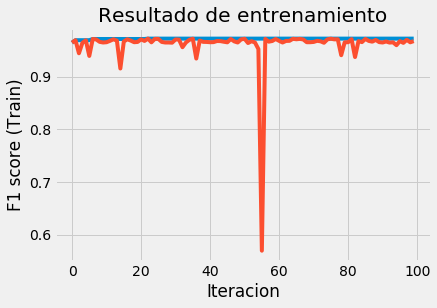

In [100]:
plt.plot(best_results)
plt.plot(results)
plt.xlabel('Iteracion')
plt.ylabel('F1 score (Train)')
plt.title('Resultado de entrenamiento')

In [137]:
clf = RandomForestClassifier( max_depth= best['max_depth'], max_features= best['max_features'], n_estimators= best['n_estimators'],random_state=best['random_state'])
clf.fit(x_train, y_train)
PREDICCIONTUNEADA=clf.predict(to_predict)
PREDICCIONTUNEADA

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

# VERIFICO TUNEO DEL MODELO

In [138]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=81, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=66,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [139]:
evaluate(clf, x_train,y_train, x_test, y_test)
f1_score(perfect_sub.target,PREDICCIONTUNEADA,average='micro')



Entrenamiento: 97.0398%
Testeo: 96.9013%.
F1 Score:  0.9690126050420168
F1 Score default:  0.9625871908687381


0.7241802022678516

# GENERO EL SUBMIT

In [147]:
result = submission_output(ids, PREDICCIONTUNEADA,"RF_tunning.csv")
result.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0


In [111]:
lg11=pd.read_csv('lg11.csv')
lg11.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [112]:
(lg11.target-result.target).sum()

1009

In [148]:
comprobar(result.target)

F1 Score:  0.7241802022678516
F1 Score default:  0.5673076923076923


In [114]:
comprobar(lg11.target)

F1 Score:  0.7146797425681888
F1 Score default:  0.6986079637423114


In [153]:
comprobar(knn_tunning.target)

F1 Score:  0.7624885075084278
F1 Score default:  0.6997287872917474
